## Project 5: 

In [37]:
# !pip install tensorflow

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn import metrics

# Modeling

### Multinomial Naive Bayes

In [39]:
df=pd.read_csv('./data/2018_gov_clean.csv')
df.head()

,Unnamed: 0,dist,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov,voted_gov_num
0,0,19,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1],0
1,1,52,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1],0
2,2,49,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,[Republican / Candidate 2],1
3,3,36,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2],1
4,4,36,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2],1


In [40]:
df.dtypes

Unnamed: 0        int64
dist              int64
gender           object
age               int64
educ             object
race             object
faminc           object
marstat          object
newsint          object
approval_gov     object
ideo5            object
voted_gov        object
voted_gov_num     int64
dtype: object

In [41]:
# df=df.drop(columns=['Unnamed: 0'], inplace=True)

In [42]:
# set up X and y
X = df.drop(columns =['voted_gov', 'voted_gov_num'])
y = df['voted_gov_num']

In [43]:
X.shape

(3676, 11)

In [44]:
X= pd.get_dummies(X, drop_first=True)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [46]:
nb=MultinomialNB()

In [47]:
nb.fit(X_train, y_train)

MultinomialNB()

In [49]:
# make predictions 
y_pred = nb.predict(X_test)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

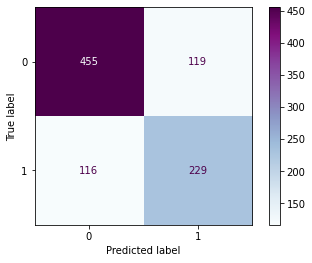

In [52]:
# plot a confusion matrix
plot_confusion_matrix(nb, X_test, y_test, cmap='BuPu', values_format='d');

In [54]:
# sensitivity and accuracy
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Precision:', prec)

Accuracy: 0.7442872687704026
Recall: 0.663768115942029
Precision: 0.6580459770114943


In [13]:
print('Accuracy on train data:', nb.score(X_train, y_train))
print('Accuracy on test data:', nb.score(X_test, y_test))

Accuracy on train data: 0.7323177366702938
Accuracy on test data: 0.7442872687704026


### Neural net classification - 1 hidden layer & early stopping

In [14]:
# random seed for tensorflow
tf.random.set_seed(1234)

In [15]:
# split into train and set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [16]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [17]:
# create model with one hidden layer
model = Sequential()
model.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [18]:
# Compile it
model.compile(loss='bce', optimizer='adam', metrics=['Accuracy', Recall(), 'Precision'])

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [20]:
# fit model
history = model.fit(
    X_train_sc, y_train, 
    validation_data=(X_test_sc, y_test), 
    epochs=100, 
    callbacks=[early_stop], 
    verbose=0,
    batch_size=32
)

Epoch 00017: early stopping


In [21]:
# save history into a df
history_df = pd.DataFrame(history.history)

In [22]:
history_df.head()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
0,0.591283,0.705114,0.691489,0.591398,0.430915,0.836779,0.707246,0.832765
1,0.362687,0.883569,0.797872,0.880470,0.319198,0.885745,0.805797,0.879747
2,0.280935,0.906057,0.842360,0.900724,0.274756,0.898803,0.834783,0.888889
3,0.242646,0.914762,0.856867,0.910586,0.254992,0.910773,0.849275,0.907121
4,0.222010,0.916576,0.855899,0.916149,0.243796,0.910773,0.849275,0.907121


In [23]:
history_df['val_Accuracy'][5:]

5     0.910773
6     0.906420
7     0.907508
8     0.909684
9     0.909684
10    0.908596
11    0.906420
12    0.907508
13    0.907508
14    0.907508
15    0.912949
16    0.910773
Name: val_Accuracy, dtype: float64

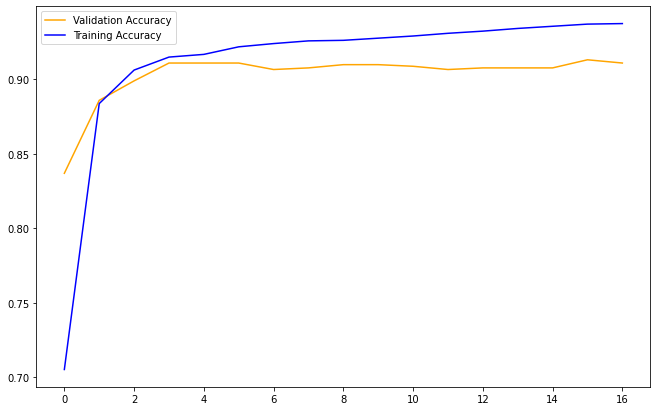

In [24]:
# plot metrics for validation data
plt.figure(figsize=(11, 7))
plt.plot(history_df['val_Accuracy'], label='Validation Accuracy', color='orange')
plt.plot(history_df['Accuracy'], label='Training Accuracy', color='blue')
plt.legend();

No handles with labels found to put in legend.


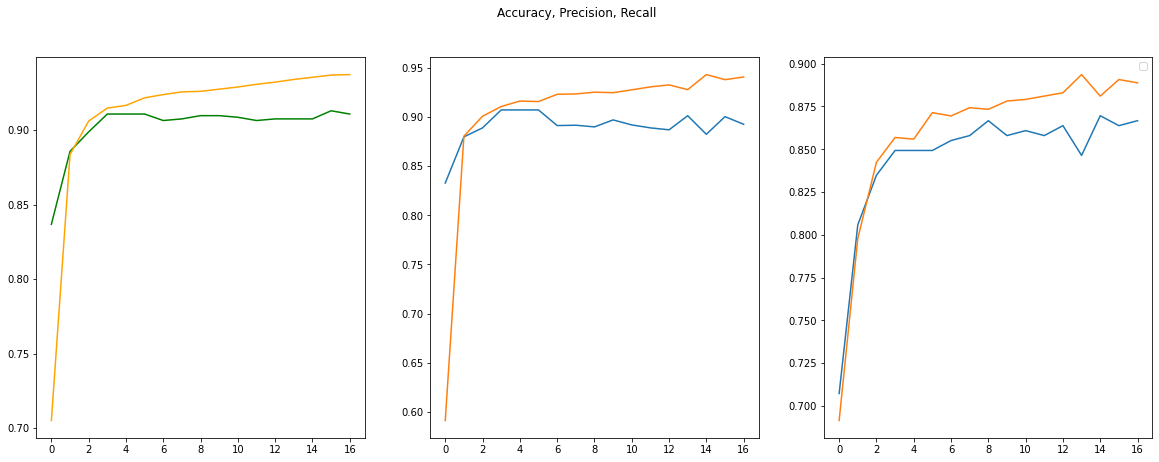

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (20, 7))
fig.suptitle('Accuracy, Precision, Recall')
ax1.plot(history_df['val_Accuracy'], label='Validation Accuracy', color='green')
ax1.plot(history_df['Accuracy'], label='Training Accuracy', color='orange')
ax2.plot(history_df['val_precision'])
ax2.plot(history_df['precision'])
ax3.plot(history_df['val_recall'])
ax3.plot(history_df['recall'])
plt.legend();

In [25]:
# evaluate 
model.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.2379 - Accuracy: 0.9108 - recall: 0.8667 - precision: 0.8925


[0.23788246512413025,
 0.9107725620269775,
 0.8666666746139526,
 0.8925372958183289]

In [26]:
# make predictions
y_pred=model.predict(X_test_sc)
y_pred[:10]

array([[0.9983752 ],
       [0.11909774],
       [0.5305984 ],
       [0.08015236],
       [0.04525724],
       [0.0776079 ],
       [0.01472563],
       [0.999033  ],
       [0.03794074],
       [0.00453642]], dtype=float32)

In [27]:
# round predicted values
y_pred =y_pred.round()
y_pred[:10]

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [28]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[538,  36],
       [ 46, 299]], dtype=int32)>

In [29]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       574
           1       0.89      0.87      0.88       345

    accuracy                           0.91       919
   macro avg       0.91      0.90      0.90       919
weighted avg       0.91      0.91      0.91       919



### Null model

- For classification problems, we build our null model based on the most frequent value in the train data, not the test data. We would use the shape of X_test for the null model array. 

In [30]:
X_test.shape

(919, 46)

In [31]:
# which one is the most frequent value?
y_train.value_counts(normalize=True)

0    0.624955
1    0.375045
Name: voted_gov_num, dtype: float64

In [32]:
# create an array of the most frequent value with number of rows equal to test data(this will be our null model predictions)
y_hat = np.zeros(919)
y_hat[:5]

array([0., 0., 0., 0., 0.])

In [33]:
# classification report for the null model
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       574
           1       0.00      0.00      0.00       345

    accuracy                           0.62       919
   macro avg       0.31      0.50      0.38       919
weighted avg       0.39      0.62      0.48       919



/Users/mekdeswassie/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mekdeswassie/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mekdeswassie/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Neural net classification - 2 hidden layers & dropout

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [36]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [37]:
model_nn = Sequential()

In [38]:
# create model
model_nn.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(10, activation='relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(1, activation='sigmoid'))

In [39]:
model_nn.compile(loss='bce', optimizer ='adam', metrics = ['Accuracy', Recall(), 'Precision'])

In [40]:
# fit model
history_2 = model_nn.fit(
    X_train_sc,
    y_train,
    validation_data=(X_test_sc, y_test),
    epochs=100,
    verbose=0
)

In [43]:
# save history into a df
history_2_df = pd.DataFrame(history_2.history)
history_2_df.head()

,loss,Accuracy,recall_1,precision,val_loss,val_Accuracy,val_recall_1,val_precision
0,0.651846,0.619151,0.237911,0.484252,0.563886,0.682263,0.205797,0.797753
1,0.514611,0.735219,0.424565,0.764808,0.427125,0.850925,0.681159,0.896947
2,0.391615,0.851288,0.769826,0.822314,0.321456,0.880305,0.811594,0.861538
3,0.319281,0.867610,0.804642,0.836181,0.277034,0.890098,0.811594,0.886076
4,0.290413,0.881030,0.813346,0.861680,0.259469,0.892274,0.826087,0.879630


In [45]:
history_2_df['val_Accuracy'][5:]

5     0.903156
6     0.906420
7     0.900979
8     0.898803
9     0.904244
        ...   
95    0.904244
96    0.907508
97    0.903156
98    0.906420
99    0.908596
Name: val_Accuracy, Length: 95, dtype: float64

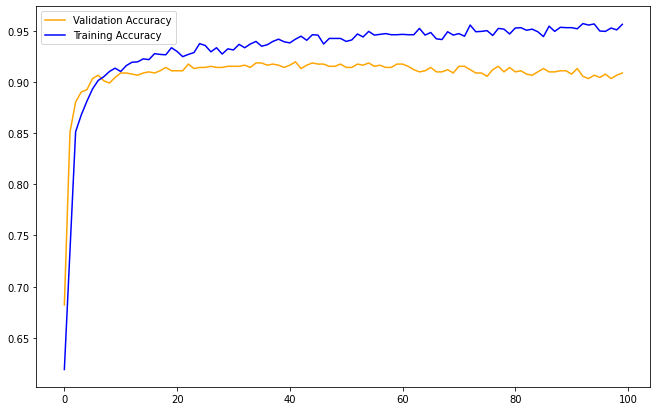

In [46]:
# plot metrics for validation data
plt.figure(figsize=(11, 7))
plt.plot(history_2_df['val_Accuracy'], label='Validation Accuracy', color='orange')
plt.plot(history_2_df['Accuracy'], label='Training Accuracy', color='blue')
plt.legend();

No handles with labels found to put in legend.


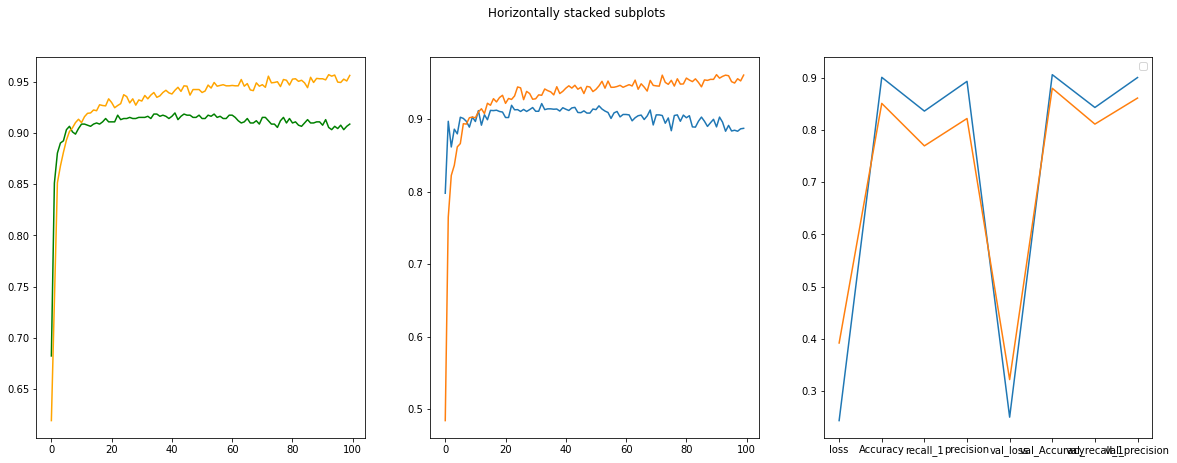

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (20, 7))
fig.suptitle('Horizontally stacked subplots')
ax1.plot(history_2_df['val_Accuracy'], label='Validation Accuracy', color='green')
ax1.plot(history_2_df['Accuracy'], label='Training Accuracy', color='orange')
ax2.plot(history_2_df['val_precision'])

ax2.plot(history_2_df['precision'])
ax3.plot(history_2_df.loc[6])
ax3.plot(history_2_df.loc[2])
plt.legend();

In [50]:
# evaluate 
model_nn.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.3669 - Accuracy: 0.9086 - recall_1: 0.8667 - precision: 0.8872


[0.3668990731239319,
 0.9085962772369385,
 0.8666666746139526,
 0.8872403502464294]

In [52]:
# make predictions
y_pred_2=model_nn.predict(X_test_sc)
y_pred_2[:10]

array([[9.9999696e-01],
       [4.9172853e-05],
       [7.2009778e-01],
       [1.8903431e-01],
       [1.2260991e-01],
       [2.4028391e-02],
       [2.6009828e-02],
       [9.9999857e-01],
       [1.0962973e-05],
       [2.3484896e-09]], dtype=float32)

In [53]:
# round predicted values
y_pred_2 =y_pred_2.round()
y_pred_2[:10]

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [55]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_2
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[536,  38],
       [ 46, 299]], dtype=int32)>

In [56]:
# classification report
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       574
           1       0.89      0.87      0.88       345

    accuracy                           0.91       919
   macro avg       0.90      0.90      0.90       919
weighted avg       0.91      0.91      0.91       919



### GridSearch with nn

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [61]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [73]:
# Add an arugment of number of layers to the function (and loop through it) 
def model_fn_deep(hidden_neurons=32, hidden_layers=5, dropout=0.5):
  model = Sequential()
  for layer in range(hidden_layers):
    if layer == 0:
      model.add(Dense(hidden_neurons, input_shape=(46,), activation='relu'))
      model.add(Dropout(dropout))
    else:
      model.add(Dense(hidden_neurons, activation='relu'))
      model.add(Dropout(dropout))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='bce', optimizer='adam')

  return model

nn_deep = KerasRegressor(build_fn=model_fn_deep, batch_size=512, verbose=0)

In [74]:
nn_params_deep = {
    'hidden_neurons': [64, 128],
    'hidden_layers': [2, 3],
    'dropout': [0.1, 0.2, 0.5],
    'epochs': [10, 20]
}

gs_deep = GridSearchCV(nn_deep, param_grid=nn_params_deep, cv=3, n_jobs=-1)
gs_deep.fit(X_train_sc, y_train)
print(gs_deep.best_params_)
gs_deep.best_score_

{'dropout': 0.2, 'epochs': 20, 'hidden_layers': 2, 'hidden_neurons': 128}


-0.23411420981089273

In [75]:
# Make predictions 
preds_deep = gs_deep.predict(X_test_sc)

In [76]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, preds_deep
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[577,   0],
       [342,   0]], dtype=int32)>

In [72]:
# classification report
print(classification_report(y_test, preds_deep))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [71]:
# evaluate 
gs_deep.evaluate(X_test_sc, y_test, verbose=2)

AttributeError: 'GridSearchCV' object has no attribute 'evaluate'